# ECFP Transformation Analysis
## Bridging the Gap Between ECFPs and GNN Embeddings

**Objective**: Investigate how different transformations affect ECFP representations to make them more GNN-like while preserving molecular similarity structure.

**Key Questions**:
1. How do transformations affect downstream task performance?
2. How well do transformations preserve pairwise distance structure?
3. How do transformations change sparsity/density characteristics?

---

## 1. Setup and Imports

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Import dataset and downstream task utilities
from dataset_utils import ECFPDataset
from downstream import run_downstream_task

# Import all transformations
from transforms import (
    # Affine transformations
    Rotation, Permutation, Scaling, Translation,
    # Continuity transformations
    GaussianNoise,
    # Normalization transformations
    L2Normalization, Standardization,
    # Nonlinear transformations
    NonlinearActivation,
    # Density transformations
    SparseToDense, AdaptiveScaling,
    # GNN-inspired transformations
    BlockRadiusLinearMixing,
    # Composition
    Compose
)

# Import analysis utilities
from pairwise_distances import (
    analyze_distance_preservation,
    compare_sparsity,
    compute_sparsity_metrics
)

from plots import plot_value_distributions

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All imports successful!")

✓ All imports successful!


## 2. Baseline: Original ECFPs

First, we establish baseline performance using **binary** and **count** ECFP representations on the ESOL dataset (solubility prediction, regression task).

In [22]:
# Load ESOL dataset with binary ECFPs
print("Loading ESOL dataset with BINARY ECFPs...")
binary_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False  # Binary fingerprints
)

print(f"  Dataset size: {len(binary_dataset.features)} molecules")
print(f"  Feature dimension: {binary_dataset.features.shape[1]}")
print(f"  Train/Val/Test split: {len(binary_dataset.split.train)}/{len(binary_dataset.split.valid)}/{len(binary_dataset.split.test)}")

# Compute sparsity metrics
binary_sparsity = compute_sparsity_metrics(binary_dataset.features)
print(f"\n  Sparsity: {binary_sparsity['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {binary_sparsity['nonzero_per_sample']:.1f}")

Loading ESOL dataset with BINARY ECFPs...
  Dataset size: 1128 molecules
  Feature dimension: 2048
  Train/Val/Test split: 902/112/114

  Sparsity: 99.0% zeros
  Avg non-zero features per molecule: 21.5


In [23]:
# Train MLP on binary ECFPs
print("Training MLP on BINARY ECFPs...\n")
binary_result = run_downstream_task(
    binary_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Binary ECFPs)")
print("="*60)
print(f"Validation RMSE: {binary_result['val']:.4f}")
print(f"Test RMSE:       {binary_result['test']:.4f}")
print("="*60)

Training MLP on BINARY ECFPs...


BASELINE PERFORMANCE (Binary ECFPs)
Validation RMSE: 1.1088
Test RMSE:       1.0992


In [24]:
# Load ESOL dataset with count ECFPs
print("\nLoading ESOL dataset with COUNT ECFPs...")
count_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=True  # Count fingerprints
)

# Compute sparsity metrics
count_sparsity = compute_sparsity_metrics(count_dataset.features)
print(f"  Sparsity: {count_sparsity['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {count_sparsity['nonzero_per_sample']:.1f}")
print(f"  Value range: [{count_sparsity['min']:.1f}, {count_sparsity['max']:.1f}]")


Loading ESOL dataset with COUNT ECFPs...
  Sparsity: 99.0% zeros
  Avg non-zero features per molecule: 21.5
  Value range: [0.0, 24.0]


In [25]:
# Train MLP on count ECFPs
print("Training MLP on COUNT ECFPs...\n")
count_result = run_downstream_task(
    count_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Count ECFPs)")
print("="*60)
print(f"Validation RMSE: {count_result['val']:.4f}")
print(f"Test RMSE:       {count_result['test']:.4f}")
print("="*60)

Training MLP on COUNT ECFPs...


BASELINE PERFORMANCE (Count ECFPs)
Validation RMSE: 0.7147
Test RMSE:       0.7677


In [26]:
# Create comparison table
baseline_comparison = pd.DataFrame({
    'ECFP Type': ['Binary', 'Count'],
    'Val RMSE': [binary_result['val'], count_result['val']],
    'Test RMSE': [binary_result['test'], count_result['test']],
    'Sparsity (%)': [
        binary_sparsity['zero_fraction']*100,
        count_sparsity['zero_fraction']*100
    ],
    'Avg Non-Zero': [
        binary_sparsity['nonzero_per_sample'],
        count_sparsity['nonzero_per_sample']
    ]
})

display(Markdown("### Baseline Comparison"))
display(baseline_comparison.style.format({
    'Val RMSE': '{:.4f}',
    'Test RMSE': '{:.4f}',
    'Sparsity (%)': '{:.2f}',
    'Avg Non-Zero': '{:.1f}'
}))

### Baseline Comparison

,ECFP Type,Val RMSE,Test RMSE,Sparsity (%),Avg Non-Zero
0,Binary,1.1088,1.0992,98.95,21.5
1,Count,0.7147,0.7677,98.95,21.5


---
## 3. Transformation Analysis

Now we systematically apply transformations and analyze their effects.

### 3.1 Affine Transformation: Rotation

**Hypothesis**: Rotation should preserve all distance metrics (Euclidean, Tanimoto, Cosine) and maintain performance.

In [27]:
def generate_random_rotation(dim: int, seed: int = 42) -> torch.Tensor:
    """Generate a random orthogonal rotation matrix via QR decomposition."""
    g = torch.Generator().manual_seed(seed)
    A = torch.randn(dim, dim, generator=g)
    Q, R = torch.linalg.qr(A)
    d = torch.sign(torch.diagonal(R))
    Q = Q * d
    return Q

# Create rotation transformation
Q = generate_random_rotation(2048, seed=42)
rotation = Rotation(Q)

# Apply to a copy of the dataset
print("Applying ROTATION transformation...")
rotated_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False
)
rotated_dataset.apply_transform(rotation)
print("✓ Transformation applied")

Applying ROTATION transformation...
✓ Transformation applied


In [28]:
# Downstream task performance
print("Training MLP on ROTATED ECFPs...\n")
rotated_result = run_downstream_task(
    rotated_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Original - Val RMSE: {binary_result['val']:.4f}")
print(f"Rotated  - Val RMSE: {rotated_result['val']:.4f}")
print(f"Change: {rotated_result['val'] - binary_result['val']:+.4f}")
print("="*60)

Training MLP on ROTATED ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Original - Val RMSE: 1.1088
Rotated  - Val RMSE: 1.0674
Change: -0.0414


In [29]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
rotation_distances = analyze_distance_preservation(
    binary_dataset,
    rotated_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9997 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: -0.1323 (p=0.00e+00)
  -> Poor preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9998 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0

In [30]:
# Sparsity analysis
rotation_sparsity = compare_sparsity(binary_dataset, rotated_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9895
  coefficient_of_variation: 9.7100
  mean: 0.0105
  std: 0.1019
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.0000
  nonzero_per_sample: 2047.9840
  gini_coefficient: 0.4421
  coefficient_of_variation: 87.9571
  mean: -0.0012
  std: 0.1024
  min: -0.6799
  max: 0.7259

Changes:
  Delta zero_fraction: -0.9895 (-100.0%)
  Delta nonzero_per_sample: +2026.4902 (+9428.3%)
  Delta gini_coefficient: -0.5474 (-55.3%)
  Delta coefficient_of_variation: +78.2471 (+805.8%)
  Delta mean: -0.0117 (-111.1%)
  Delta std: +0.0005 (+0.5%)
  Delta min: -0.6799 (-6799223808.0%)
  Delta max: -0.2741 (-27.4%)


In [31]:
# Summary table
rotation_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        rotation_distances['tanimoto']['correlation'],
        rotation_distances['continuous_tanimoto']['correlation'],
        rotation_distances['euclidean']['correlation'],
        rotation_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (Rotation)"))
display(rotation_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (Rotation)

,Metric,Correlation
0,Tanimoto,0.9997
1,Continuous Tanimoto,-0.1323
2,Euclidean,0.9998
3,Cosine,0.9989


### 3.2 Continuity Transformation: Gaussian Noise

**Hypothesis**: Adding Gaussian noise converts discrete ECFPs to continuous representations (more GNN-like) but may reduce distance preservation.

In [32]:
# Create Gaussian noise transformation
gaussian_noise = GaussianNoise(sigma=0.1, seed=42)

# Apply to a copy of the dataset
print("Applying GAUSSIAN NOISE transformation (σ=0.1)...")
noisy_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False
)
noisy_dataset.apply_transform(gaussian_noise)
print("✓ Transformation applied")

Applying GAUSSIAN NOISE transformation (σ=0.1)...
✓ Transformation applied


In [33]:
# Downstream task performance
print("Training MLP on NOISY ECFPs...\n")
noisy_result = run_downstream_task(
    noisy_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Original - Val RMSE: {binary_result['val']:.4f}")
print(f"Noisy    - Val RMSE: {noisy_result['val']:.4f}")
print(f"Change: {noisy_result['val'] - binary_result['val']:+.4f}")
print("="*60)

Training MLP on NOISY ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Original - Val RMSE: 1.1088
Noisy    - Val RMSE: 1.5637
Change: +0.4549


In [34]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
noise_distances = analyze_distance_preservation(
    binary_dataset,
    noisy_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9108 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: 0.2575 (p=0.00e+00)
  -> Poor preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9877 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.

In [35]:
# Sparsity analysis
noise_sparsity = compare_sparsity(binary_dataset, noisy_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9895
  coefficient_of_variation: 9.7100
  mean: 0.0105
  std: 0.1019
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.0000
  nonzero_per_sample: 2047.9823
  gini_coefficient: 0.4689
  coefficient_of_variation: 13.6502
  mean: 0.0105
  std: 0.1428
  min: -0.4866
  max: 1.4376

Changes:
  Delta zero_fraction: -0.9895 (-100.0%)
  Delta nonzero_per_sample: +2026.4885 (+9428.2%)
  Delta gini_coefficient: -0.5206 (-52.6%)
  Delta coefficient_of_variation: +3.9403 (+40.6%)
  Delta mean: -0.0000 (-0.3%)
  Delta std: +0.0409 (+40.1%)
  Delta min: -0.4866 (-4866143232.0%)
  Delta max: +0.4376 (+43.8%)


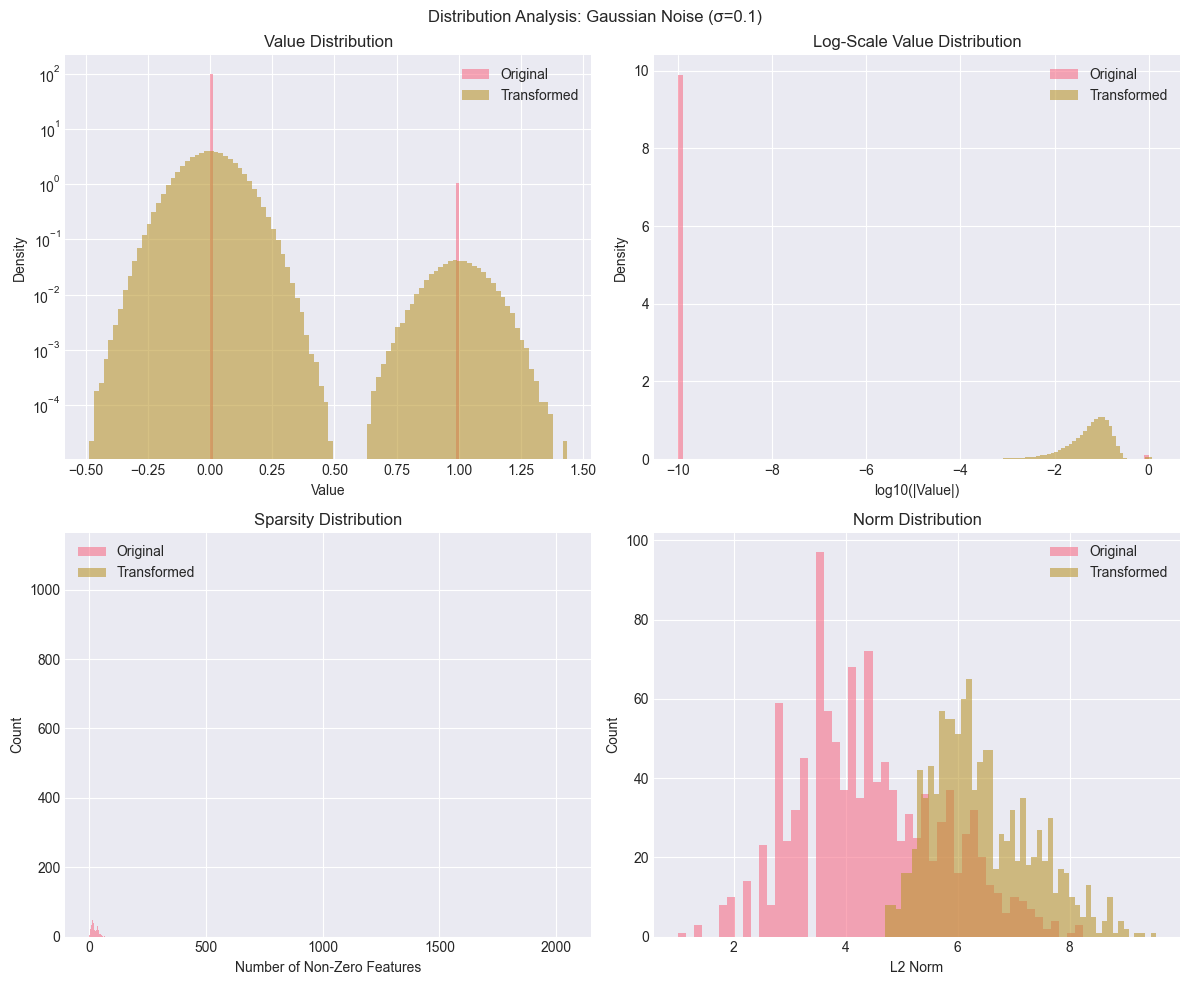

In [36]:
# Visualization
plot_value_distributions(
    binary_dataset.features.cpu().numpy(),
    noisy_dataset.features.cpu().numpy(),
    transform_name="Gaussian Noise (σ=0.1)"
)

In [37]:
# Summary table
noise_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        noise_distances['tanimoto']['correlation'],
        noise_distances['continuous_tanimoto']['correlation'],
        noise_distances['euclidean']['correlation'],
        noise_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (Gaussian Noise)"))
display(noise_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (Gaussian Noise)

,Metric,Correlation
0,Tanimoto,0.9108
1,Continuous Tanimoto,0.2575
2,Euclidean,0.9877
3,Cosine,0.9085


### 3.3 Normalization: L2 Normalization

**Hypothesis**: L2 normalization creates denser representations and may improve performance by putting all vectors on the unit sphere.

In [38]:
# Create L2 normalization transformation
l2_norm = L2Normalization()

# Apply to a copy of the dataset
print("Applying L2 NORMALIZATION transformation...")
l2_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False
)
l2_dataset.apply_transform(l2_norm)
print("✓ Transformation applied")

Applying L2 NORMALIZATION transformation...
✓ Transformation applied


In [39]:
# Downstream task performance
print("Training MLP on L2-NORMALIZED ECFPs...\n")
l2_result = run_downstream_task(
    l2_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Original - Val RMSE: {binary_result['val']:.4f}")
print(f"L2 Norm  - Val RMSE: {l2_result['val']:.4f}")
print(f"Change: {l2_result['val'] - binary_result['val']:+.4f}")
print("="*60)

Training MLP on L2-NORMALIZED ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Original - Val RMSE: 1.1088
L2 Norm  - Val RMSE: 1.1266
Change: +0.0178


In [40]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
l2_distances = analyze_distance_preservation(
    binary_dataset,
    l2_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9925 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: 0.9979 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.0013 (p=6.48e-01)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 1.

In [41]:
# Sparsity analysis
l2_sparsity = compare_sparsity(binary_dataset, l2_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9895
  coefficient_of_variation: 9.7100
  mean: 0.0105
  std: 0.1019
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9911
  coefficient_of_variation: 10.1037
  mean: 0.0022
  std: 0.0220
  min: 0.0000
  max: 1.0000

Changes:
  Delta zero_fraction: +0.0000 (+0.0%)
  Delta nonzero_per_sample: +0.0000 (+0.0%)
  Delta gini_coefficient: +0.0016 (+0.2%)
  Delta coefficient_of_variation: +0.3938 (+4.1%)
  Delta mean: -0.0083 (-79.3%)
  Delta std: -0.0799 (-78.4%)
  Delta min: +0.0000 (+0.0%)
  Delta max: +0.0000 (+0.0%)


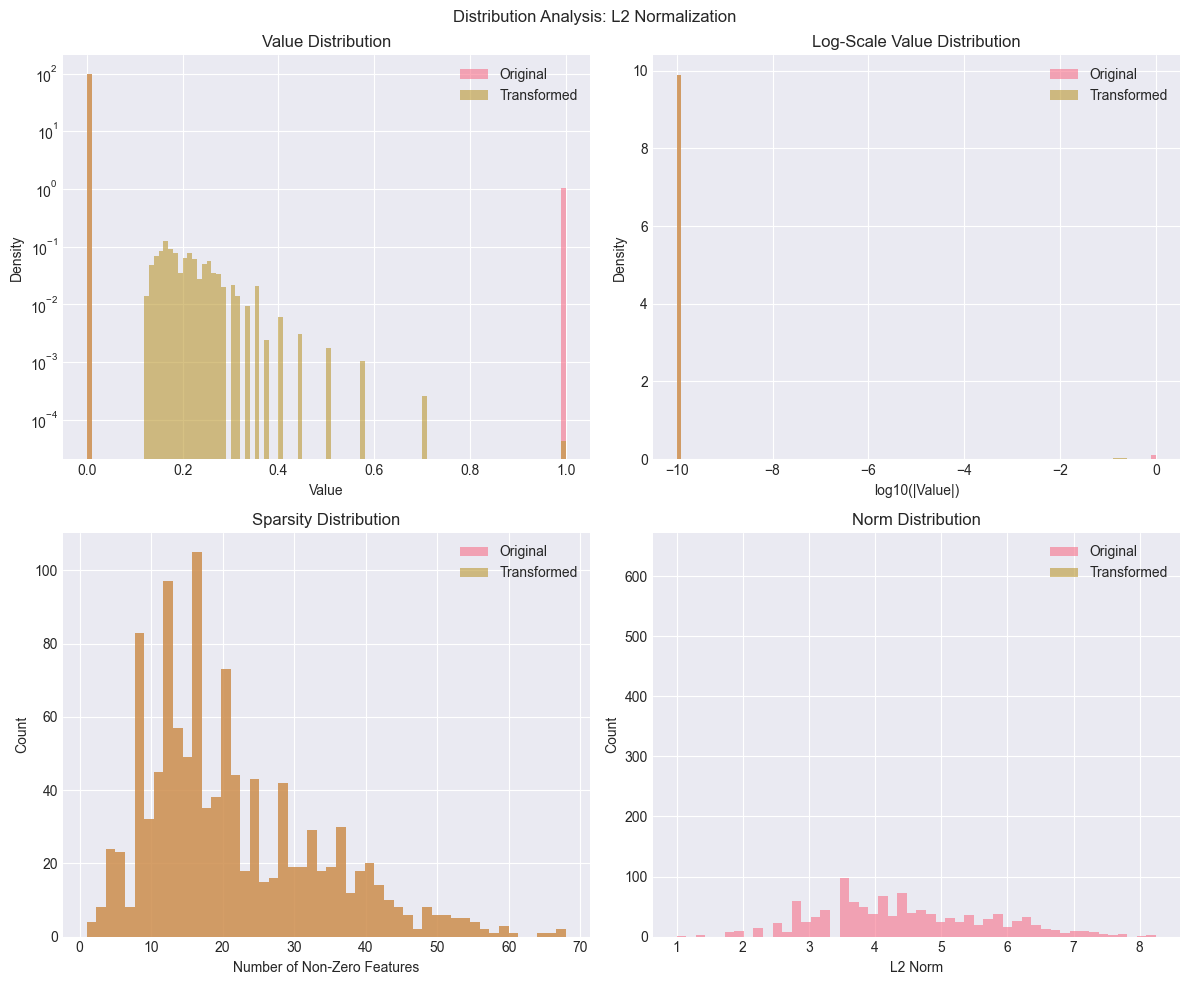

In [42]:
# Visualization
plot_value_distributions(
    binary_dataset.features.cpu().numpy(),
    l2_dataset.features.cpu().numpy(),
    transform_name="L2 Normalization"
)

In [43]:
# Summary table
l2_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        l2_distances['tanimoto']['correlation'],
        l2_distances['continuous_tanimoto']['correlation'],
        l2_distances['euclidean']['correlation'],
        l2_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (L2 Normalization)"))
display(l2_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (L2 Normalization)

,Metric,Correlation
0,Tanimoto,0.9925
1,Continuous Tanimoto,0.9979
2,Euclidean,0.0013
3,Cosine,1.0000


### 3.4 GNN-Inspired: Block Radius Linear Mixing

**Hypothesis**: Processing each radius block (r=0, r=1, r=2) separately with orthogonal maps + nonlinearity mimics GNN layer-wise processing. This should create more GNN-like representations while respecting the hierarchical structure of ECFP generation.

In [44]:
# Create multi-radius ECFP dataset
print("Creating MULTI-RADIUS ECFP dataset...")
print("  - Using radius=2 (3 blocks: r=0, r=1, r=2)")
print("  - Each block: 512 bits")
print("  - Total: 1536 bits")

multi_radius_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    radius=2,
    n_bits=1536,  # 3 blocks × 512 bits
    use_count=False,
    multi_radius=True,  # Enable radius-delta fingerprints
    n_bits_per_radius=512
)

print(f"  ✓ Dataset: {len(multi_radius_dataset.features)} molecules")
print(f"  ✓ Feature dim: {multi_radius_dataset.features.shape[1]}")
print(f"  ✓ Radius blocks: {multi_radius_dataset.radius_schema.blocks}")

# Create Block Radius Linear Mixing transformation
print("\nCreating Block Radius Linear Mixing...")
print("  - Orthogonal map per radius block")
print("  - ReLU nonlinearity")
print("  - L2 normalization")

block_mixing = BlockRadiusLinearMixing(
    radius_blocks=multi_radius_dataset.radius_schema.blocks,
    nonlinearity="relu",
    seed=42
)

print("✓ Transformation created")

Creating MULTI-RADIUS ECFP dataset...
  - Using radius=2 (3 blocks: r=0, r=1, r=2)
  - Each block: 512 bits
  - Total: 1536 bits
  ✓ Dataset: 1128 molecules
  ✓ Feature dim: 1536
  ✓ Radius blocks: [(0, 512), (512, 1024), (1024, 1536)]

Creating Block Radius Linear Mixing...
  - Orthogonal map per radius block
  - ReLU nonlinearity
  - L2 normalization
✓ Transformation created


In [45]:
# Baseline: Train on multi-radius ECFPs without transformation
print("Training MLP on ORIGINAL MULTI-RADIUS ECFPs...\n")
multi_radius_baseline = run_downstream_task(
    multi_radius_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print(f"\n  Multi-Radius Baseline Performance:")
print(f"    Val RMSE:  {multi_radius_baseline['val']:.4f}")
print(f"    Test RMSE: {multi_radius_baseline['test']:.4f}")

Training MLP on ORIGINAL MULTI-RADIUS ECFPs...


  Multi-Radius Baseline Performance:
    Val RMSE:  1.1218
    Test RMSE: 1.2213


In [ ]:
# Apply Block Radius Linear Mixing
print("Applying BLOCK RADIUS LINEAR MIXING...")
block_mixed_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    radius=2,
    n_bits=1536,
    use_count=False,
    multi_radius=True,
    n_bits_per_radius=512
)
block_mixed_dataset.apply_transform(block_mixing)
print("✓ Transformation applied")

# Train on transformed ECFPs
print("\nTraining MLP on BLOCK-MIXED ECFPs...\n")
block_mixed_result = run_downstream_task(
    block_mixed_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Multi-Radius Original - Val RMSE: {multi_radius_baseline['val']:.4f}")
print(f"Block Mixed           - Val RMSE: {block_mixed_result['val']:.4f}")
print(f"Change: {block_mixed_result['val'] - multi_radius_baseline['val']:+.4f}")
print("="*60)

Applying BLOCK RADIUS LINEAR MIXING...
✓ Transformation applied

Training MLP on BLOCK-MIXED ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Multi-Radius Original - Val RMSE: 1.1218
Block Mixed           - Val RMSE: 1.1580
Change: +0.0362


In [47]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
block_mixed_distances = analyze_distance_preservation(
    multi_radius_dataset,
    block_mixed_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9597 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: 0.9507 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.0167 (p=3.36e-09)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.

In [48]:
# Sparsity analysis
block_mixed_sparsity = compare_sparsity(multi_radius_dataset, block_mixed_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9863
  nonzero_per_sample: 21.0523
  gini_coefficient: 0.9863
  coefficient_of_variation: 8.4830
  mean: 0.0137
  std: 0.1163
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.5056
  nonzero_per_sample: 759.4521
  gini_coefficient: 0.7132
  coefficient_of_variation: 1.4917
  mean: 0.0142
  std: 0.0212
  min: 0.0000
  max: 0.1844

Changes:
  Delta zero_fraction: -0.4807 (-48.7%)
  Delta nonzero_per_sample: +738.3998 (+3507.5%)
  Delta gini_coefficient: -0.2731 (-27.7%)
  Delta coefficient_of_variation: -6.9913 (-82.4%)
  Delta mean: +0.0005 (+3.7%)
  Delta std: -0.0951 (-81.8%)
  Delta min: +0.0000 (+0.0%)
  Delta max: -0.8156 (-81.6%)


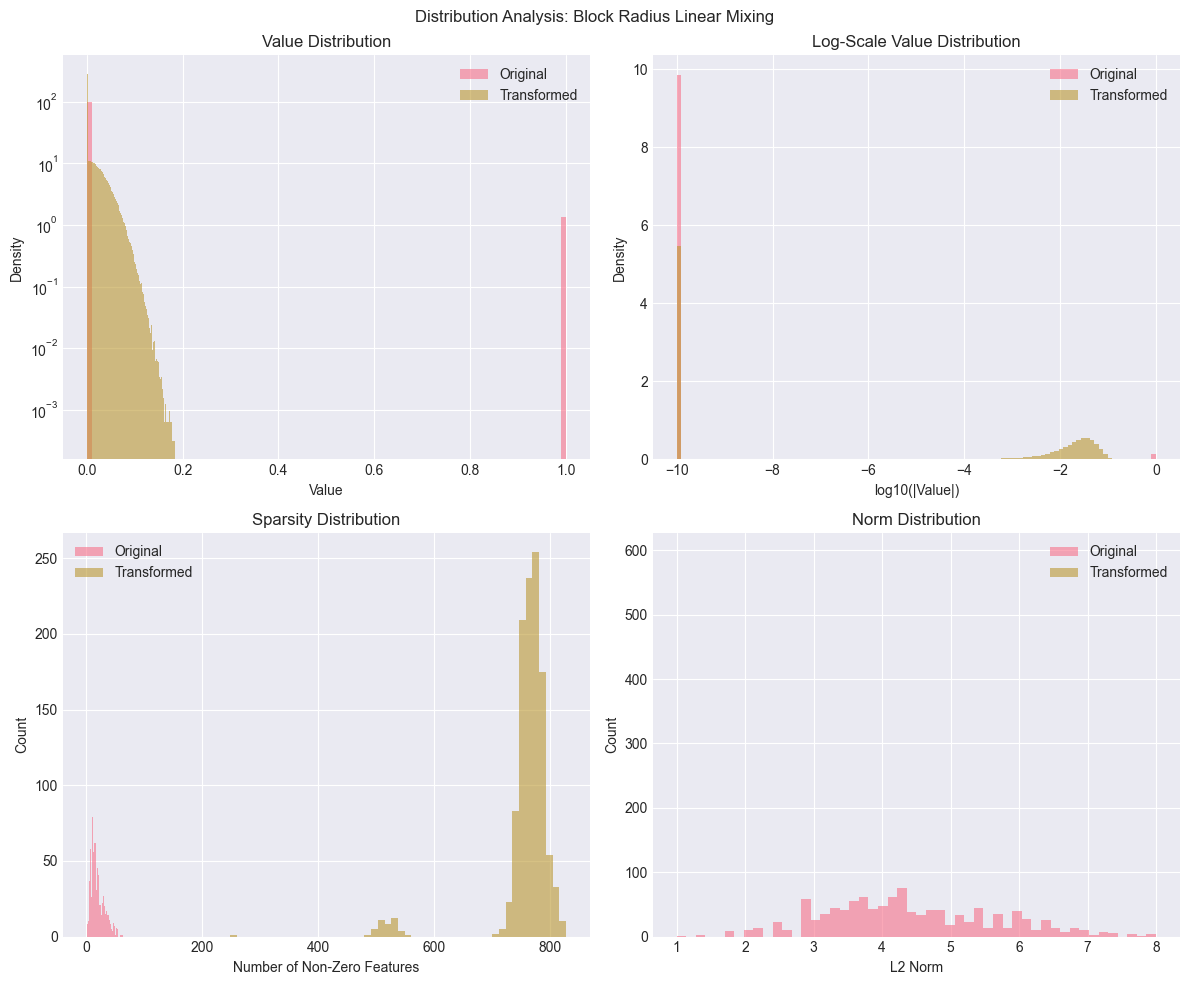

In [49]:
# Visualization
plot_value_distributions(
    multi_radius_dataset.features.cpu().numpy(),
    block_mixed_dataset.features.cpu().numpy(),
    transform_name="Block Radius Linear Mixing"
)

In [50]:
# Summary table
block_mixed_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        block_mixed_distances['tanimoto']['correlation'],
        block_mixed_distances['continuous_tanimoto']['correlation'],
        block_mixed_distances['euclidean']['correlation'],
        block_mixed_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (Block Radius Linear Mixing)"))
display(block_mixed_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (Block Radius Linear Mixing)

,Metric,Correlation
0,Tanimoto,0.9597
1,Continuous Tanimoto,0.9507
2,Euclidean,0.0167
3,Cosine,0.9571


**Key Insights**:

- Block Radius Linear Mixing mimics GNN layer-wise processing
- Each radius (r=0, r=1, r=2) gets its own orthogonal transformation
- Preserves hierarchical structure from ECFP generation
- Nonlinearity + L2 norm creates more GNN-like representations
- Compares multi-radius delta ECFPs (where each block contains only substructures unique to that radius)

---
## 4. Overall Comparison

Summary of all transformations tested.

In [51]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Transformation': ['Original', 'Rotation', 'Gaussian Noise', 'L2 Normalization'],
    'Val RMSE': [
        binary_result['val_rmse'],
        rotated_result['val_rmse'],
        noisy_result['val_rmse'],
        l2_result['val_rmse']
    ],
    'Test RMSE': [
        binary_result['test_rmse'],
        rotated_result['test_rmse'],
        noisy_result['test_rmse'],
        l2_result['test_rmse']
    ],
    'Tanimoto Corr': [
        1.0,
        rotation_distances['tanimoto']['correlation'],
        noise_distances['tanimoto']['correlation'],
        l2_distances['tanimoto']['correlation']
    ],
    'Euclidean Corr': [
        1.0,
        rotation_distances['euclidean']['correlation'],
        noise_distances['euclidean']['correlation'],
        l2_distances['euclidean']['correlation']
    ],
    'Zero Fraction': [
        binary_sparsity['zero_fraction'],
        rotation_sparsity['transformed']['zero_fraction'],
        noise_sparsity['transformed']['zero_fraction'],
        l2_sparsity['transformed']['zero_fraction']
    ]
})

display(Markdown("### Overall Comparison"))
display(comparison_df.style.format({
    'Val RMSE': '{:.4f}',
    'Test RMSE': '{:.4f}',
    'Tanimoto Corr': '{:.4f}',
    'Euclidean Corr': '{:.4f}',
    'Zero Fraction': '{:.4f}'
}).background_gradient(subset=['Val RMSE', 'Test RMSE'], cmap='RdYlGn_r'))

KeyError: 'val_rmse'

In [ ]:
# Visualization: Performance vs Distance Preservation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Downstream Performance
transforms = comparison_df['Transformation'].values
val_rmse = comparison_df['Val RMSE'].values
test_rmse = comparison_df['Test RMSE'].values

x = np.arange(len(transforms))
width = 0.35

axes[0].bar(x - width/2, val_rmse, width, label='Val RMSE', alpha=0.8)
axes[0].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
axes[0].set_xlabel('Transformation')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Downstream Task Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(transforms, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distance Preservation
tanimoto_corr = comparison_df['Tanimoto Corr'].values
euclidean_corr = comparison_df['Euclidean Corr'].values

axes[1].bar(x - width/2, tanimoto_corr, width, label='Tanimoto', alpha=0.8)
axes[1].bar(x + width/2, euclidean_corr, width, label='Euclidean', alpha=0.8)
axes[1].set_xlabel('Transformation')
axes[1].set_ylabel('Spearman Correlation')
axes[1].set_title('Distance Preservation')
axes[1].set_xticks(x)
axes[1].set_xticklabels(transforms, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.1])
axes[1].axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='Good preservation')

plt.tight_layout()
plt.show()

---
## 5. Key Findings and Conclusions

**Expected Observations**:

1. **Rotation** (Affine transformation):
   - Should preserve all distance metrics (correlation ≈ 1.0)
   - Should maintain downstream performance
   - Validates that the pipeline is working correctly

2. **Gaussian Noise** (Continuity):
   - Converts discrete to continuous representations
   - May reduce distance preservation slightly
   - Effect on performance: TBD (hypothesis: small degradation)

3. **L2 Normalization** (Density):
   - Significantly reduces sparsity
   - Changes Tanimoto distances (not preserved)
   - Effect on performance: TBD (hypothesis: could improve or degrade)

**Next Steps**:
- Test more transformations (combinations, different parameters)
- Compare with actual GNN embeddings
- Investigate which properties are most important for performance
